## Numerical Inverse Kinematics (IK)

You are expected to implement Jacobian transpose, Jacobian Pseudoinverse and Quadratic Programming (QP) based controller introduced in the lecture. 

In [1]:
import numpy as np
from numpy import nan
import matplotlib.pyplot as plt
import pinocchio as pin
import os, subprocess
import time

### Pinocchio library for robot kinematics  
We will use the Pinocchio library in this assignment to compute robots' kinematics.  
Let's import a UR5 robot introduced in the lecture.  
To visualize the robot you need to run gepetto-gui in a terminal under virtual environment ik_env.

In [2]:
from example_robot_data.robots_loader import load
robot = load("ur5") # let's use a ur-5 robot introduced in the course

In [3]:
Viewer = pin.visualize.GepettoVisualizer
# Viewer = pin.visualize.MeshcatVisualizer

viz = Viewer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(loadModel=True)
viz.display(robot.q0) # visualize the default configuration of the robot.

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


Pinocchio stores the robot models like link mass, geometric parameters in robot.model and intermediate compute results in rdata. In other words, you call function from pin, and use the parameters in model and store the results in rdata and they process this as separate data structure.

In [4]:
rmodel = robot.model
rdata = rmodel.createData()

In [5]:
# This initial configurate is chosen intentionally to showcase 
# the different impact for manipulability by different IK methods.
q_rand = np.array([ 2.05563934, -1.68031123,  1.06696164, -3.92205628,  0.93923542,
       -0.])
q_curr = q_rand.copy()
viz.display(q_curr)

In [6]:
# To get the joint information
for n in rmodel.names:
    print(n)

jointIndex = rmodel.getJointId("wrist_3_joint")
print("Index of wrist_3_joint:", jointIndex)
## the index of universe joint is 0

universe
shoulder_pan_joint
shoulder_lift_joint
elbow_joint
wrist_1_joint
wrist_2_joint
wrist_3_joint
Index of wrist_3_joint: 6


In [7]:
# To get the frame information. Joint frame is movable, but other frames are supposed
# to be rigidly attached to their parent joint frame.
for f in robot.model.frames:
    print(f.name)

universe
root_joint
world
world_joint
base_link
base_link-base_fixed_joint
base
shoulder_pan_joint
shoulder_link
shoulder_lift_joint
upper_arm_link
elbow_joint
forearm_link
wrist_1_joint
wrist_1_link
wrist_2_joint
wrist_2_link
wrist_3_joint
wrist_3_link
ee_fixed_joint
ee_link
wrist_3_link-tool0_fixed_joint
tool0


In [8]:
# compute the frame forward kinematics to get the pose information of each frame.
pin.framesForwardKinematics(rmodel, rdata, q_curr)
toolFrameIndex = rmodel.getFrameId('tool0')
print("Index of tool frame: ", toolFrameIndex)
# and we can easily get the SE3 pose of this frame
rdata.oMf[toolFrameIndex]

Index of tool frame:  22


  R =
-0.762533 -0.458789 -0.456132
-0.284201  0.870928 -0.400892
 0.581183 -0.176061 -0.794499
  p = -0.218529 0.0763896  0.688673

### Manipulability measure
As we introduced in course this is a typical manipulability measure:
$$w(q) = \sqrt{det(J(q)J(q)^T)}$$

In [9]:
def manipulability(q:np.ndarray) -> float:
    ''' q: shape (n,) numpy array
        try to calc the manipulability, notice the output should be a scalar!
    '''
    _ = pin.computeJointJacobians(rmodel,rdata,q)
    J = pin.getFrameJacobian(rmodel,rdata,toolFrameIndex,pin.LOCAL_WORLD_ALIGNED)
    
    #### Your Code Here!
    man = np.sqrt(np.linalg.det(J@J.T))
    ####
    return man

In [10]:
# test
assert np.abs(manipulability(q_rand) - 0.02134) < 1e-4
print("Seems ok.")

Seems ok.


### Jacobian transpose and Pseudoinverse law for inverse kinematics
Let's implement a jacobian transpose and a pseudoinverse controller for IK. The goal is to put the end effector to a goal position.  
For more details, check the slides of Lecture 2.

But the basic idea is quite simple, with a p controller defined in cartesian space:
$$ \dot{x} = \alpha (x_{des} - x)$$
use need to use the techniques introduced in the lecture to generate joint space control. The gain $\alpha$ needs to be selected by hands.

In [11]:
# the goal position in cartesian space and mark it as a purple marker.
p_des = np.array([-0.5,-0.5,0.1]) # you can play around with this position
import vizutils
vizutils.addViewerSphere(viz,'world/ball', .02, [.8, .2, 1., .5])
vizutils.applyViewerConfiguration(viz, 'world/ball', p_des.tolist()+[1, 0, 0, 0])

In [12]:
def JacobianTransposeCtl(Jacobian:np.ndarray, error:np.ndarray, gain:float) -> np.ndarray:
    ''' Input:
                Jacobian: For UR5, it is a 3 by 6 position Jacobian, 
                          because we only concern about the position control thus 
                          it is a redundant system.
                error:    3 by 1 position error
                gain:     hand-tuned propotional gain
        Output:
                v_ctr:    joint velocity control, 6 by 1 vector
    '''
    #### Your Code Here!
    v_ctl = v_ctl = gain * Jacobian.T @ x_error
    ####
    return v_ctl

def JacobianPseudoinverseCtl(Jacobian, error, gain):
    ''' The definition is similar to JacobianTransposeCtl
        tips:
                sometimes M @ M.T can be singular, you may want to add a small number to the diagonal entries
                of this matrix to avoid weird action, e.g. joint velocity is infinite. This approach can be
                shown to be equivalent to the Levenberg-damping in numerical optimization.
    '''
    #### Your Code Here!
    v_ctl = gain * Jacobian.T @ np.linalg.inv(Jacobian@Jacobian.T + np.eye(3)*1e-4) @ error
    ####
    return v_ctl

In [ ]:
dt = 1e-3

jt_man = []
ji_man = []

# control loop
for controller in ["jt", "ji"]:
    print("Run the ", controller, " controller")
    if controller == "jt":
        control_func = JacobianTransposeCtl
        p_gain = 5.
    else:
        control_func = JacobianPseudoinverseCtl
        p_gain = 0.5
    error = float("inf")
    while not error < 1e-3:
        p_curr = rdata.oMf[toolFrameIndex].translation.copy()
        if controller == "jt":
            jt_man_i = manipulability(q_curr)
            jt_man.append(jt_man_i.reshape(1,-1))
        elif controller == "ji":
            ji_man_i = manipulability(q_curr)
            ji_man.append(ji_man_i.reshape(1,-1))

        _ = pin.computeJointJacobians(rmodel,rdata,q_curr)
        pin.framesForwardKinematics(rmodel, rdata, q_curr)
        Jee = pin.getFrameJacobian(rmodel,rdata,toolFrameIndex,pin.LOCAL_WORLD_ALIGNED)
        # we only need position jacobian, therefore this is a redundant control problem.
        Jp = Jee[:3,:]

        position_error = p_des - p_curr
        x_error = position_error

        # tune the position gain to make the movement reasonable
        v_control = control_func(Jp, x_error, p_gain)

        q_curr += dt*v_control
        viz.display(q_curr)
        error = np.linalg.norm(x_error)
        time.sleep(dt)
    
#     reset the configuration
    q_curr = q_rand.copy()
    pin.framesForwardKinematics(rmodel, rdata, q_curr)
    viz.display(q_curr)

Run the  jt  controller


As we expected the jacobian transpose will converge slower than jacobian pseudoinverse. Recall in numerical optimization, the gradient descent method (jacobian transpose) will be slower than newton method (jacobian pseudoinverse). This trick can be used to generate more complicated motion in cartesian space, like a circle or square. The only thing you need is to make the target position moving through your desired path.

### Quadractic Programming (QP)-based IK with manipulability maximization
We can also formulate the control as an optimization problem
$$\begin{split}
\min_{\dot{q}} \frac{1}{2} ||\dot{q}&-\dot{q}_0||^{2}_{2}\\
\text{s.t.} \quad \dot{x}&=J\dot{q} \\
\dot{q}_0 &= k_0 (\frac{\partial w(q)}{\partial q})^T\\
q_{min}& \leq \dot{q} \leq q_{max}
\end{split}$$
It can be shown that the solution of this optimization is to guarantee the cartesian space velocity $\dot{x}$ as the primary task while trying to achieve a secondary task whose objective function is defined as $w(q)$.   
The constant values in this QP problem is the cartesian velocity $\dot{x}$ that has to be designed by cartesian space control and the secondary objective function $w(q)$. We will set the secondary task $w(q)$ as manipulability maximization as

$$w(q) = \sqrt{det(J(q)J(q)^T)}.$$
And you probably have found that to compute the partial derivative to get $\dot{q}_0$, we will confront the derivation of $\partial J(q) / \partial q$ which is not trivial. For this task, we only need to work out the finite difference solution by $[\frac{\partial w(q)}{\partial q}]_i = \frac{f(q+\delta_{q_i})-f(q)}{\delta_{q_i}}$, where $[.]_i$ denotes the $i$th entry and $\delta_{q_i}$ is a small scalar perturbation added to $i$th joint. Here we have spoilt the notation and added scalar $\delta_{q_i}$ to the corresponding joint angle in $q$.

Let's use the most commonly used optimization library qpsolvers.
Introduction: https://qpsolvers.github.io/qpsolvers/quadratic-programming.html  
Just read a bit how can we formulate a qp problem.

In [17]:
from qpsolvers import solve_qp

In [18]:
# let's get the joint velocity bound constraints
# With optimization-based controller the robot can generate more reasonable motion w.r.t velocity
vmax = rmodel.velocityLimit.copy()
vmin = -rmodel.velocityLimit.copy()

In [19]:
# below is a sloppy implementation of the finite-difference gradient for subtask
def get_dot_q0(curr_q, k0=1., delta=0.001):
    ''' curr_q:    current joint angle
        k0:        gain of the subtask
        delta:     small perturbation to the input
    '''
    n = len(curr_q)
    man_gradient = np.zeros((n,))
    for i in range(n):
        curr_man = manipulability(curr_q)
        purterb_q = curr_q.copy()
        purterb_q[i] += delta
        disturbed_man = manipulability(purterb_q)
        man_gradient[i] = (disturbed_man - curr_man) / delta
        
    dot_q0 = man_gradient
    return dot_q0

def generateQP(dot_q0, Jacobian, x_dot):
    ''' 
    Input:
            dot_q0:    subtask gradient
            Jacobian:  Jacobian matrix with shape (3,6)
            x_dot:     desired cartesian velocity of the end-effector
    Output:
            P:         Quadratic term in QP objective
            q:         linear term in QP objective
            A:         coefficient term in QP equality constraint
            b:         target term in QP equality constraint
            
    We can define the joint velocity limit as inquality constraints, but 
    the QP solver has a better (faster) way to deal with these "bound" constraints, thus 
    they are defined in the solver function. Check the code for details.
    You will need to check https://qpsolvers.github.io/qpsolvers/quadratic-programming.html
    '''
    #### Your Code Here!
    n = len(dot_q0)
    P = 0.5*np.eye(n)
    q = -dot_q0
    A = Jacobian
    b = x_dot
    ####
    return P, q, A, b

In [20]:
# control loop
error = float("inf")
p_gain = 0.5
subtask_gain = 1000

qp_man = []
acc_factor = 1.1
while not error < 1e-3:
    pin.framesForwardKinematics(rmodel, rdata, q_curr)
    p_curr = rdata.oMf[toolFrameIndex].translation.copy()
    
    qp_man_i = manipulability(q_curr)
    qp_man.append(qp_man_i.reshape(1,-1))
    _ = pin.computeJointJacobians(rmodel,rdata,q_curr)
    Jee = pin.getFrameJacobian(rmodel,rdata,toolFrameIndex,pin.LOCAL_WORLD_ALIGNED)
    Jp = Jee[:3,:]
    
    position_error = p_des - p_curr
#     x_error = np.concatenate([position_error, np.zeros((3,))])
    x_dot = p_gain * position_error

    dot_q0 = get_dot_q0(q_curr, k0=subtask_gain)
    P, q, A, b = generateQP(dot_q0, Jp, x_dot)
    v_control = solve_qp(P, q, A=A, b=b, lb=vmin, ub=vmax, solver="osqp") # bound constraints defined here.
    if type(v_control) != np.ndarray:
        # if the cartesian velocity was too large, the qp solver will return None.
        # we reduce the gain and run the solver again...
        p_gain *= 0.9
        continue
    
    q_curr += dt*v_control
    
    viz.display(q_curr)
    error = np.linalg.norm(position_error)
    time.sleep(dt)

/home/jiayun/miniconda3/envs/ik_env/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(
/home/jiayun/miniconda3/envs/ik_env/lib/python3.10/site-packages/qpsolvers/conversions/ensure_sparse_matrices.py:38: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a scipy.sparse.csc_matrix rather than as a numpy.ndarray
  warnings.warn(


Check the different final poses by these controllers. The QP controller will generate the final pose which is more "manipulable".

In [21]:
# reset the robot
q_curr = q_rand.copy()
pin.framesForwardKinematics(rmodel, rdata, q_curr)
viz.display(q_curr)

In [22]:
# prepare the data to visualization
jt_man = np.concatenate(jt_man)
ji_man = np.concatenate(ji_man)
qp_man = np.concatenate(qp_man)

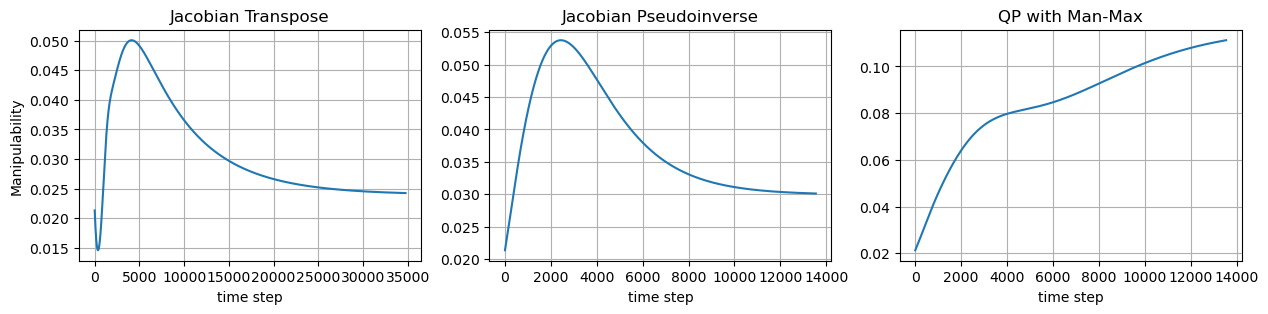

In [23]:
# showcase the variation of manipulability during these reaching processes
plt.figure(figsize=[15,3])
plt.subplot(131)
plt.ylabel("Manipulability")
plt.xlabel("time step")
plt.title("Jacobian Transpose")
plt.grid()
plt.plot(jt_man)
plt.subplot(132)
plt.xlabel("time step")
plt.title("Jacobian Pseudoinverse")
plt.plot(ji_man)
plt.grid()
plt.subplot(133)
plt.plot(qp_man)
plt.xlabel("time step")
plt.title("QP with Man-Max")
plt.grid()
plt.show()

Notice when the impact from cartesian-velocity constraints becomes weaker, the QP controller will then generate different behaviour compared with the JT and JI controller to maximize the manipulability through null-space motion.

### Conclusion
Jacobian transpose will converge slower than jacobian pseudoinverse control.  
The QP-based IK can be utilized to achieve sub-tasks using the null-space motion of the manipulator. You can check the poses of the manipulator and the QP-based IK will generate a more "comfortable" pose compared with the JT and JI control.

|![](ji.png)|![](qp.png)|
|:-:|:-:|
|Jacobian Pseudoinverse|Quadratic Programming|